In [1]:
%load_ext autoreload
%autoreload 2
# %matplotlib notebook

from utils import *
import sys
sys.path.append('/Users/theoares/lqcd/utilities')
from plottools import *
from scipy.integrate import quad

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['/Users/theoares/Library/Fonts/cmunrm.otf'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


## Initialize parameters and Laplace kernel

#### Sparse modeling

This notebook uses principles of sparse modeling to reconstruct a spectral function $\rho(\omega)$ from finite Green's function data $G(\tau)$. $G$ is constructed from the spectral function by a Laplace transform,
$$
    G(\tau) = \int_\mathbb{R} d\omega\, e^{-\omega\tau}\rho(\omega).
$$
This method will discretize the Laplace transform to write it as a matrix equation. The Green's function $G(\tau)$ is evaluated at discrete $\{\tau_i\}$ of size $N_\tau$, and the spectral function is evaluated at discrete $\{\omega_j\}$ of size $N_\omega$, and the discretized vectors are $\mathbf G_i = G(\tau_i)$ and $\mathbf \rho_j = \rho(\omega_j)$. In this form, the previous equation becomes a matrix equation,
$$
    \mathbf{G}_i = K_{ij} \mathbf{\rho}_j,
$$
where $K_{ij} = e^{-\tau_i \omega_j}$ is the discretized Laplace kernel, a matrix of size $N_\tau\times N_\omega$. 

The approach we will take to solving this problem is to exploit the sparsity of $\rho(\omega)$ in a so-called "Intermediate Representation (IR)". An IR is defined by performing a singular value decomposition of $K_{ij}$:
$$
    K = U S V^\dagger,
$$
where $U, V$ are respectively unitary $N_\tau\times N_\tau$ and $N_\omega\times N_\omega$ matrices, and S is the diagonal matrix of singular values. The IR specific to $K$ (as we will have different representations depending on the dimension of $U$ and $V$) is defined as a rotation of $\mathbf G$ and $\mathbf \rho$ by the corresponding unitary matrices $U$ and $V^\dagger$:
\begin{align}
    \mathbf G' = U^\dagger \mathbf G && \mathbf \rho' = V^\dagger \mathbf \rho.
\end{align}
In this representation the components of $\mathbf G'$ and $\mathbf \rho'$ are related by multiplication with a singular value $s_\ell\equiv S_{\ell\ell}$ (note here there is no sum on $\ell$):
$$
    \mathbf G'_\ell = s_\ell \mathbf \rho'_\ell.
$$

In this representation, the spectral function is \textbf{sparse}, meaning that it has a large number of components which are zero or very close to 0. We can exploit the sparsity to solve the Least Absolute Shrinkage and Selection Operator (LASSO) problem, which is the optimization problem which corresponds to the minimization of the following function,
$$
    F_{LASSO}(\mathbf x) = \frac{1}{2} ||\mathbf G - K \mathbf x||_2^2 + \lambda ||\mathbf x||_1,
$$
where $||\cdot||_p$ is the $L^p$ norm and $\lambda$ is a \textbf{hyperparameter}, meaning that it is chosen and tweaked by the user to find the best solution to the inverse problem. The $L_1$ norm term is interpreted as a penalty; the optimization searches through the space of $\mathbf x$ and tries to minimize the objective function $|| \mathbf G - K\mathbf x||_2^2$, subject to also trying to minimize $||\mathbf x||_1$. If $\lambda$ is small, minimization of the objective function is most important; however if $\lambda$ is large, minimization of the $L_1$ norm is more important, and so the choise of $\lambda$ is a choice between getting the closest solution to the input data and having a solution which is sparse. 

Note that in our problem, we want to perform the minimization subject to the sparsity of $\mathbf{\rho}'$, the components of $\mathbf \rho$ in an IR. That is, we solve for $\mathbf{\rho}'$ in the following optimization problem:
$$
    \mathbf{\rho'} = \arg\min_\mathbf{\rho'} \left[\frac{1}{2}|| \mathbf{G}' - S \mathbf{\rho}' ||_2^2 + \lambda ||\mathbf{\rho}'||_1\right]
$$
and then rotate back to $\mathbf{\rho} = V \mathbf{\rho}'$ afterward.

In [2]:
Ntau = 16
Nomega = 32
# Nomega = 128
taus = np.arange(Ntau)
omega_line = np.linspace(0, 2, Nomega)    # to simulate spectral function on
DelOmega = (omega_line[-1] - omega_line[0]) / Nomega
# omega_bounds = [0, 2]
# domega = 0.01
# omegas = np.arange(omega_bounds[0], omega_bounds[1], domega)
omegas = omega_line                    # to use for recon

In [3]:
kernel = laplace_kernel(taus, omegas)
U, svals, Vdag = np.linalg.svd(kernel)
V = hc(Vdag)
S = np.pad(np.diag(svals), [(0, 0), (0, len(omegas) - len(taus))])

In [4]:
# SVD sanity checks
print(check_mat_equal(U @ hc(U), np.eye(len(U))))
print(check_mat_equal(V @ Vdag, np.eye(len(Vdag))))
print(check_mat_equal(U @ S @ Vdag, kernel))

(True, 6.661338147750939e-16)
(True, 8.881784197001252e-16)
(True, 3.3306690738754696e-15)


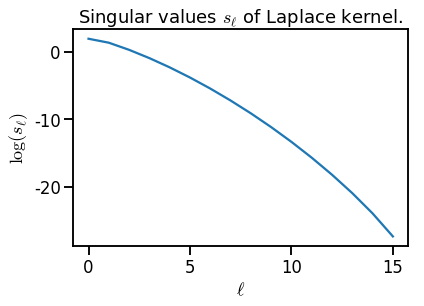

In [5]:
# The area where the singular values asymptote is likely machine precision. 
with sns.plotting_context('talk'):
    plt.figure()
    plt.plot(np.log(svals))
    plt.xlabel('$\ell$')
    plt.ylabel('$\log(s_\ell)$')
    plt.title('Singular values $s_\ell$ of Laplace kernel.')
    plt.show()

In [6]:
# # simulate a spectral function which is known to be sparse in IR
# rhop_supp = np.arange(20, 30)
# rhop_sim = np.zeros((Nomega), dtype = np.float64)
# rhop_sim[rhop_supp] = 1.
# rho_sim = V @ rhop_sim
# G = kernel @ rho_sim

In [7]:
# with sns.plotting_context('talk'):
#     fig, ax = plt.subplots(1, 2, figsize = (15, 5))
#     plot_1d_function(ax[0], omega_line, rhop_sim, title = 'ρ\' in sparse basis', ax_label = ['ω', 'ρ'], \
#                      legend = False, colors = ['c'])
#     plot_1d_function(ax[1], omega_line, rho_sim, title = 'ρ = V ρ\' in regular basis', ax_label = ['ω', 'ρ'], \
#                      legend = False, colors = ['r'])
#     plt.tight_layout()

In [8]:
# Two types of spectral fns to simulate
omega0 = 0.8
delOmega = 0.3
def rho(omega):
    return np.exp(- (omega - omega0) ** 2 / (2 * (delOmega ** 2))) / (np.sqrt(2 * np.pi) * delOmega)# * DelOmega

# omega_supp = [0.8, 1.1]
# rho = lambda omega : 1 / (omega_supp[1] - omega_supp[0]) if omega > omega_supp[0] and omega < omega_supp[1] else 0

# def signal(tau):
#     integrand = lambda omega : np.exp(-omega * tau) * rho(omega)
#     return quad(integrand, 0, np.inf)[0]
rho_dat = np.array([rho(a) * DelOmega for a in omega_line])
rhop_dat = Vdag @ rho_dat

np.random.seed(10)
# G = np.array([signal(t) for t in taus])
G = kernel @ rho_dat
print('Evaluating Greens function at tau = it = ' + str(taus))
# print('Sum of ρ_i Δω = ' + str(np.sum(rho_dat) * DelOmega))
print('Sum of ρ_i = ' + str(np.sum(rho_dat)))

Evaluating Greens function at tau = it = [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
Sum of ρ_i = 0.9660945804495996


In [9]:
check_mat_equal(hc(U) @ G, S @ rhop_dat)

(True, 1.3322676295501878e-15)

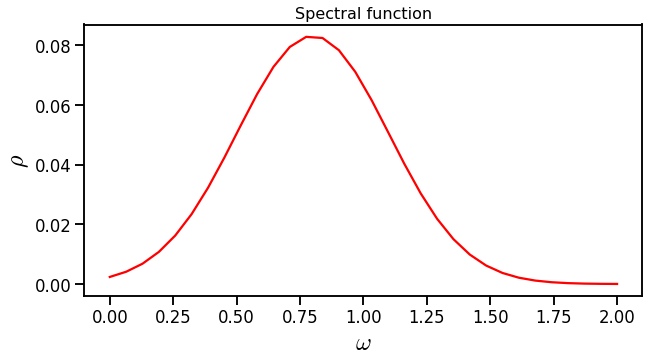

In [10]:
with sns.plotting_context('talk'):
    fig, ax = plt.subplots(1, figsize = (10, 5))
    plot_1d_function(ax, omega_line, rho_dat, colors = 'r', title = 'Spectral function', \
                     ax_label = ['$\\omega$', '$\\rho$'], legend = False)

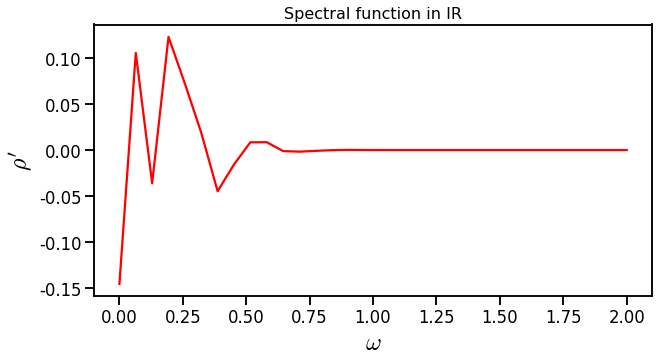

In [11]:
with sns.plotting_context('talk'):
    fig, ax = plt.subplots(1, figsize = (10, 5))
    plot_1d_function(ax, omega_line, rhop_dat, colors = 'r', title = 'Spectral function in IR', \
                     ax_label = ['$\\omega$', '$\\rho\'$'], legend = False)

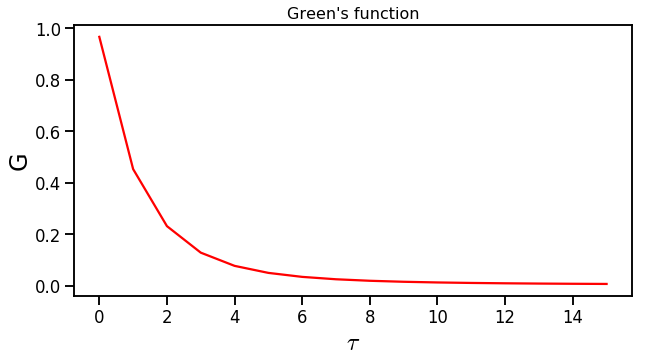

In [12]:
with sns.plotting_context('talk'):
    fig, ax = plt.subplots(1, figsize = (10, 5))
    plot_1d_function(ax, taus, G, colors = 'r', title = 'Green\'s function', ax_label = ['$\\tau$', 'G'], \
                     legend = False)

## Solve inverse problem with ADMM

#### ADMM parameters

The Alternating Direction Method of Multipliers (ADMM) is an algorithm which solves the LASSO problem. The idea is to impose constraints by adding terms to the minimization problem. This is performed by adding in auxiliary variables to the optimization problem and minimizing / maximizing them all jointly. The basic setup is a bit more lenient than the optimization problem we already have, in which we want to jointly minimize the following equation:
$$
    f(\vec x) + g(\vec z)\; \mathrm{s.t.}\; A\vec x + B\vec z = \vec c
$$
Here $g$ is non-differentiable and will be taken to be the regularizing term. In ADMM, we form the augmented Lagrangian to incorporate the constraint, which adds it in as a part of the optimization rather than doing a projection onto the space which satisfies the constraint:
$$
    L_\rho(\vec x, \vec y, \vec z) = f(\vec x) + g(\vec z) + \frac{1}{2}\rho || A\vec x + B\vec z - \vec c||_2^2 + \vec y^T (A\vec x + B\vec z - \vec c)
$$
where here $\rho$ is a parameter and $\vec y$ is a Lagrange multiplier. Each constraint that one enforces in the optimization will add an extra parameter $\rho'$ and Lagrange multiplier $\vec y'$, added to the augmented Lagrangian in the same way. 

The idea is that you solve this Lagrangian with an optimization technique similar to dual ascent (which maximizes a dual problem to find the equivalent solution to the optimization): solve for the optimal value $\vec y^*$:
$$
    y^* = \arg\max_\vec{y} \min_{\vec z}\min_{\vec x} L_\rho(\vec x, \vec y, \vec z).
$$
The "alternating" part of the name comes from this, because you solve the $\vec x$ minimization first, then the $\vec z$ minimization, and finally maximize $\vec y$-- the optimization occurs over alternating directions. Finally, from $y^*$, one can change variables to get the optimal solutions to the original problem, $x^*$ and $z^*$.

#### ADMM updates

Updates: (General update scheme)

#### Convergence

TODO edit this

Some terminology: $\vec x$ and $\vec z$ are called the \textbf{primal variables}, and $\vec y$ (or the scale version $\vec u = \vec y / \rho$) is called the \textbf{dual variable}. You get an additional dual variable for each constract that you impose on the system. There are a few different residuals that you can consider in this problem. The obvious one is the \textbf{primal residual}:
$$
    r^k = f(\vec x^k) + g(\vec z^k)
$$
which measures how close to zero the objective function that you're minimizing is. In our case, the primal residual takes the form:
$$
    r^k = ||\vec G'^k - S \rho'^k||_2^2 + \lambda ||\rho'^k||_1
$$
You can also consider the \textbf{dual residual}, which measures how close the constraints are to being satisfied:
$$
    d^k = ||A\vec x^k + B\vec z^k - \vec c||_2^2
$$

#### Application to our problem

TODO edit this section, some things are not written out well

For our problem, we need to split up the optimization into the form $f(\vec \rho') + g(\vec z')$, and we have two constraints: non-negativity and the sum rule. We need to add in a bunch of auxiliary variables consistent with the previous cell to deal with these. The variables which are added in are:
- $\vec z'$, which converges to $\rho'$. This is added to give the optimization problem the correct form. The additional constraint to enforce is:
$$
    \vec z' = \vec \rho'
$$
- $\vec z$, which converges to the original $\vec\rho$. The additional constraint to enforce is:
$$
    \vec z = V \vec\rho'
$$
To enforce these constraints, additional hyperparameters $\mu$ and $\mu'$ are added in, as well as scaled Lagrange multipliers $\vec u$ and $\vec u'$. 
- $\mu$ and $\vec u$: These enforce the constraint $\vec z = V\vec \rho'$. This is added to the augmented Lagrangian (the function to min / max over) as:
$$
    \frac{1}{2}\mu ||\vec z - V\vec \rho' ||_2^2 + \vec u^T (\vec z - V\vec\rho')
$$
- $\mu'$ and $\vec u'$: These enforce the constraint $\vec z' = \vec \rho'$, and $\mu'$ controls the speed of convergence (not sure why at the moment). The following term is added to the augmented Lagrangian:
$$
    \frac{1}{2} \mu' ||\vec z' - \vec\rho' ||_2^2 + \vec u'^T (\vec z - \vec \rho')
$$

In [13]:
# initialize parameters. Here we'll use the default settings.
params = ADMMParams.default_params(Nomega, d = (Ntau, Nomega))
# params.lam = 0.0001
# params.mu = 0.05
# params.mup = 0.1
params.lam = 1e-5
params.mu = 1e-5
params.mup = 1e-5
params.max_iters = 10000
params.eps = 1e-5

In [14]:
rho_recon, xp, primal_resid, dual_resid, iters = \
            admm(G, taus, omegas, params, resid_norm = lpnorm(1), disp_iters = 1000)

Starting solver.
Iteration 1000: primal residual = 0.06474201893139868, dual resid = 0.28134560869412484, elapsed time = 0.13220977783203125
Iteration 2000: primal residual = 0.06470798942976419, dual resid = 0.22027253977196903, elapsed time = 0.2593259811401367
Iteration 3000: primal residual = 0.06468020794967294, dual resid = 0.18328536040380913, elapsed time = 0.4174661636352539
Iteration 4000: primal residual = 0.06465728764240856, dual resid = 0.14883227323591927, elapsed time = 0.566918134689331
Iteration 5000: primal residual = 0.06463803531861477, dual resid = 0.12194712693022394, elapsed time = 0.7179620265960693
Iteration 6000: primal residual = 0.0646219705775756, dual resid = 0.11275867204787997, elapsed time = 0.8541500568389893
Iteration 7000: primal residual = 0.06460848361931854, dual resid = 0.10598357408720505, elapsed time = 0.9740321636199951
Iteration 8000: primal residual = 0.06459702100385707, dual resid = 0.10038984362614203, elapsed time = 1.1223957538604736


(-0.018445688188657716, 0.11042861304147072)


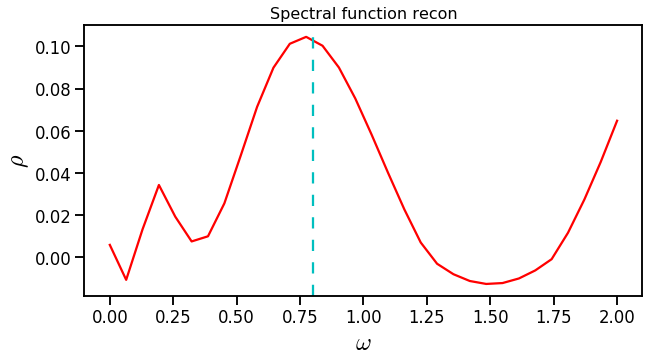

In [15]:
# currently normalized so that sum_i rho_i = 1, but we want sum_i Delta\omega = 1
with sns.plotting_context('talk'):
    fig, ax = plt.subplots(1, figsize = (10, 5))
    plot_1d_function(ax, omegas, rho_recon, colors = 'r', title = 'Spectral function recon', \
                     ax_label = ['$\\omega$', '$\\rho$'], legend = False)
    print(ax.get_ylim())
    add_line(ax, omega0, color = 'c', dashes = (5, 5), label = '$\\omega_0$')

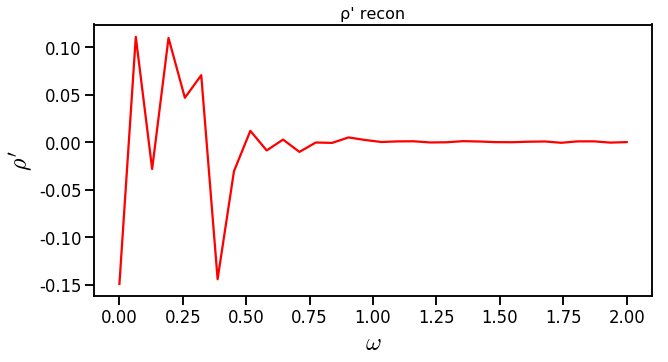

In [16]:
# looks close to the original
with sns.plotting_context('talk'):
    fig, ax = plt.subplots(1, figsize = (10, 5))
    plot_1d_function(ax, omegas, xp, colors = 'r', title = 'ρ\' recon', \
                     ax_label = ['$\\omega$', '$\\rho\'$'], legend = False)

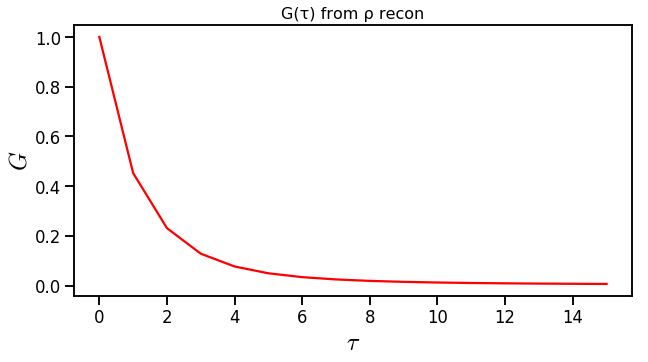

In [17]:
# looks close to the original, but the scale is absolutely off
Grecon = kernel @ rho_recon
with sns.plotting_context('talk'):
    fig, ax = plt.subplots(1, figsize = (10, 5))
    plot_1d_function(ax, taus, Grecon, colors = 'r', title = 'G(τ) from ρ recon', \
                     ax_label = ['$\\tau$', '$G$'], legend = False)

#### Scan the parameter range

In [18]:
# lam_list = [10 ** n for n in np.arange(-8, 1., 2.)]
lam_list = [10 ** n for n in np.arange(-5, 1., 1.)]
mu_list = lam_list
mup_list = lam_list
max_iters = 10000
rho_recons, p_resids, d_resids = parameter_scan(G, taus, omegas, lam_list, mu_list, mup_list, max_iters)

(lambda, mu, mup) = (1e-05, 1e-05, 1e-05)
Starting solver.
Iteration 1000: primal residual = 0.033905504287188554, dual resid = 0.09451419620099645, elapsed time = 0.14698076248168945
Iteration 2000: primal residual = 0.03390555265173559, dual resid = 0.07626123243534583, elapsed time = 0.2884559631347656
Iteration 3000: primal residual = 0.03390561067483135, dual resid = 0.06297349426930912, elapsed time = 0.4549870491027832
Iteration 4000: primal residual = 0.03390566954035077, dual resid = 0.05288180956801175, elapsed time = 0.5946319103240967
Iteration 5000: primal residual = 0.033905725783595075, dual resid = 0.045095164259196456, elapsed time = 0.7554969787597656
Iteration 6000: primal residual = 0.033905776536939936, dual resid = 0.039440434385032315, elapsed time = 0.9076428413391113
Iteration 7000: primal residual = 0.03390582079577114, dual resid = 0.035601273435801994, elapsed time = 1.0486888885498047
Iteration 8000: primal residual = 0.03390585876233514, dual resid = 0.033

Iteration 10000: primal residual = 0.033915705268367145, dual resid = 0.006461332148166547, elapsed time = 1.2303900718688965
Run complete. 
   Iterations: 10000
   Primal residual: 0.033915705268367145
   Dual residual: 0.006461332148166547
   Elapsed time: 1.230597972869873
(lambda, mu, mup) = (1e-05, 0.0001, 1e-05)
Starting solver.
Iteration 1000: primal residual = 0.03390556283345053, dual resid = 0.048383775730294766, elapsed time = 0.1192178726196289
Iteration 2000: primal residual = 0.033905673546420635, dual resid = 0.02982456619143703, elapsed time = 0.23572587966918945
Iteration 3000: primal residual = 0.03390576251445897, dual resid = 0.020751450836490545, elapsed time = 0.36217784881591797
Iteration 4000: primal residual = 0.03390582365654219, dual resid = 0.017205506708976314, elapsed time = 0.48084187507629395
Iteration 5000: primal residual = 0.03390587255518177, dual resid = 0.012650052163547984, elapsed time = 0.5988080501556396
Iteration 6000: primal residual = 0.0339

Iteration 7000: primal residual = 0.0339157128463869, dual resid = 0.006452612984120159, elapsed time = 0.8134188652038574
Iteration 8000: primal residual = 0.03391571411268564, dual resid = 0.006451213707893193, elapsed time = 0.9269988536834717
Iteration 9000: primal residual = 0.03391571537896477, dual resid = 0.00644981475621928, elapsed time = 1.072416067123413
Iteration 10000: primal residual = 0.033915716645224595, dual resid = 0.006448416129027211, elapsed time = 1.214906930923462
Run complete. 
   Iterations: 10000
   Primal residual: 0.033915716645224595
   Dual residual: 0.006448416129027211
   Elapsed time: 1.2150888442993164
(lambda, mu, mup) = (1e-05, 0.001, 1e-05)
Starting solver.
Iteration 1000: primal residual = 0.033905739132373186, dual resid = 0.006187265774173697, elapsed time = 0.11787080764770508
Iteration 2000: primal residual = 0.03390583304611255, dual resid = 0.002390368038997289, elapsed time = 0.25411200523376465
Iteration 3000: primal residual = 0.03390588

Iteration 4000: primal residual = 0.03391575439864285, dual resid = 0.006403496444420858, elapsed time = 0.471649169921875
Iteration 5000: primal residual = 0.03391576704763607, dual resid = 0.006389638444132037, elapsed time = 0.5952010154724121
Iteration 6000: primal residual = 0.033915779694206935, dual resid = 0.006375812556008913, elapsed time = 0.7074120044708252
Iteration 7000: primal residual = 0.033915792338244044, dual resid = 0.006362018709859129, elapsed time = 0.828603982925415
Iteration 8000: primal residual = 0.03391580497963775, dual resid = 0.006348256835649477, elapsed time = 0.9469320774078369
Iteration 9000: primal residual = 0.03391581761827802, dual resid = 0.006334526863506698, elapsed time = 1.063575029373169
Iteration 10000: primal residual = 0.03391583025405604, dual resid = 0.00632082872371653, elapsed time = 1.1917829513549805
Run complete. 
   Iterations: 10000
   Primal residual: 0.03391583025405604
   Dual residual: 0.00632082872371653
   Elapsed time: 1.

Iteration 2000: primal residual = 0.03391595325927113, dual resid = 0.006156775022889077, elapsed time = 0.2297060489654541
Iteration 3000: primal residual = 0.03391607845572515, dual resid = 0.006025887531170034, elapsed time = 0.35129666328430176
Iteration 4000: primal residual = 0.03391620316016013, dual resid = 0.005897998383778229, elapsed time = 0.4622819423675537
Iteration 5000: primal residual = 0.03391632728374937, dual resid = 0.005773043177184883, elapsed time = 0.5889618396759033
Iteration 6000: primal residual = 0.033916450743994825, dual resid = 0.00565095895289557, elapsed time = 0.7012817859649658
Iteration 7000: primal residual = 0.03391657346439615, dual resid = 0.005531684164908728, elapsed time = 0.8282849788665771
Iteration 8000: primal residual = 0.033916695374134144, dual resid = 0.005415158647830577, elapsed time = 0.9367499351501465
Iteration 9000: primal residual = 0.033916816407773144, dual resid = 0.005301323585626252, elapsed time = 1.0460479259490967
Itera

Iteration 10000: primal residual = 0.033919842140538344, dual resid = 0.0006047300891587284, elapsed time = 1.1813609600067139
Run complete. 
   Iterations: 10000
   Primal residual: 0.033919842140538344
   Dual residual: 0.0006047300891587284
   Elapsed time: 1.1816768646240234
(lambda, mu, mup) = (1e-05, 0.1, 1.0)
Starting solver.
Iteration 1000: primal residual = 0.03391686462425677, dual resid = 0.005001308512427055, elapsed time = 0.13605594635009766
Iteration 2000: primal residual = 0.033917961029022343, dual resid = 0.004096711342549878, elapsed time = 0.2585301399230957
Iteration 3000: primal residual = 0.03391893897069299, dual resid = 0.003377734298807569, elapsed time = 0.40103697776794434
Iteration 4000: primal residual = 0.03391978906189236, dual resid = 0.002810326031586601, elapsed time = 0.5280909538269043
Iteration 5000: primal residual = 0.033919999169059, dual resid = 0.0009124245754602999, elapsed time = 0.6679670810699463
Iteration 6000: primal residual = 0.0339200

Iteration 9000: primal residual = 0.03390705941723105, dual resid = 0.0051609911462164185, elapsed time = 1.0642719268798828
Iteration 10000: primal residual = 0.03390723199841252, dual resid = 0.0038272049488445193, elapsed time = 1.177884817123413
Run complete. 
   Iterations: 10000
   Primal residual: 0.03390723199841252
   Dual residual: 0.0038272049488445193
   Elapsed time: 1.1780049800872803
(lambda, mu, mup) = (0.0001, 1e-05, 0.0001)
Starting solver.
Iteration 1000: primal residual = 0.033907141491254594, dual resid = 0.006426181717850875, elapsed time = 0.11127710342407227
Iteration 2000: primal residual = 0.033908861584787696, dual resid = 0.012664108931579487, elapsed time = 0.2309250831604004
Iteration 3000: primal residual = 0.03391027334860075, dual resid = 0.010563659332983692, elapsed time = 0.3409850597381592
Iteration 4000: primal residual = 0.03391130321481823, dual resid = 0.00491545982388626, elapsed time = 0.4646871089935303
Iteration 5000: primal residual = 0.033

Iteration 6000: primal residual = 0.033906763171200324, dual resid = 0.0034267304377017175, elapsed time = 0.7170391082763672
Iteration 7000: primal residual = 0.033906941535639216, dual resid = 0.002472793260209288, elapsed time = 0.8260819911956787
Iteration 8000: primal residual = 0.033907116151510305, dual resid = 0.001958124196899157, elapsed time = 0.9352691173553467
Iteration 9000: primal residual = 0.03390728433524225, dual resid = 0.0019918758419979862, elapsed time = 1.055459976196289
Iteration 10000: primal residual = 0.03390745124801152, dual resid = 0.0016624733263708106, elapsed time = 1.1646687984466553
Run complete. 
   Iterations: 10000
   Primal residual: 0.03390745124801152
   Dual residual: 0.0016624733263708106
   Elapsed time: 1.164781093597412
(lambda, mu, mup) = (0.0001, 0.0001, 0.0001)
Starting solver.
Iteration 1000: primal residual = 0.03390723147682571, dual resid = 0.003830271963602908, elapsed time = 0.12056684494018555
Iteration 2000: primal residual = 0.

Iteration 3000: primal residual = 0.03390634614870724, dual resid = 0.0005689004324362459, elapsed time = 0.3927121162414551
Iteration 4000: primal residual = 0.033906501727087895, dual resid = 0.0007948052244856355, elapsed time = 0.5458641052246094
Iteration 5000: primal residual = 0.03390666829318709, dual resid = 0.000575265365081963, elapsed time = 0.6703329086303711
Iteration 6000: primal residual = 0.033906845237412844, dual resid = 0.0004323163210687149, elapsed time = 0.8310019969940186
Iteration 7000: primal residual = 0.03390703831935153, dual resid = 0.0002773255769846244, elapsed time = 0.9847712516784668
Iteration 8000: primal residual = 0.03390721300628545, dual resid = 0.00022758023646135935, elapsed time = 1.1096079349517822
Iteration 9000: primal residual = 0.03390737338364245, dual resid = 0.00028052624917415577, elapsed time = 1.2322640419006348
Iteration 10000: primal residual = 0.033907518903171355, dual resid = 0.0003702402750045151, elapsed time = 1.363806009292

Iteration 1000: primal residual = 0.03390601283143397, dual resid = 0.00035797222765403405, elapsed time = 0.1431427001953125
Iteration 2000: primal residual = 0.03390621234666415, dual resid = 0.00011955030891745334, elapsed time = 0.25485992431640625
Iteration 3000: primal residual = 0.0339063885756374, dual resid = 5.454350696832446e-05, elapsed time = 0.368682861328125
Iteration 4000: primal residual = 0.03390653412327263, dual resid = 0.0001423245028989821, elapsed time = 0.5033307075500488
Iteration 5000: primal residual = 0.03390665916020536, dual resid = 6.208836075732814e-05, elapsed time = 0.6271276473999023
Iteration 6000: primal residual = 0.033906836415496126, dual resid = 4.48956580249091e-05, elapsed time = 0.7501318454742432
Iteration 7000: primal residual = 0.033907032098531416, dual resid = 2.9155265504589215e-05, elapsed time = 0.8659467697143555
Iteration 8000: primal residual = 0.03390720803316412, dual resid = 2.3163244494132884e-05, elapsed time = 0.9890048503875

Iteration 9000: primal residual = 0.03396304206714264, dual resid = 0.005710770938115335, elapsed time = 1.1053760051727295
Iteration 10000: primal residual = 0.03396290168344424, dual resid = 0.005692898627385638, elapsed time = 1.2236809730529785
Run complete. 
   Iterations: 10000
   Primal residual: 0.03396290168344424
   Dual residual: 0.005692898627385638
   Elapsed time: 1.2238080501556396
(lambda, mu, mup) = (0.0001, 0.1, 1e-05)
Starting solver.
Iteration 1000: primal residual = 0.033906013969277164, dual resid = 2.550712860839444e-05, elapsed time = 0.12242698669433594
Run complete. 
   Iterations: 1737
   Primal residual: 0.03390618989220652
   Dual residual: 8.697644780824718e-06
   Elapsed time: 0.22097492218017578
(lambda, mu, mup) = (0.0001, 0.1, 0.0001)
Starting solver.
Iteration 1000: primal residual = 0.03390751107700678, dual resid = 3.8278341272893336e-05, elapsed time = 0.11190605163574219
Iteration 2000: primal residual = 0.03390868432696351, dual resid = 5.9951651

Iteration 3000: primal residual = 0.03395184979951922, dual resid = 0.00021758944784498372, elapsed time = 0.40352773666381836
Iteration 4000: primal residual = 0.0339527581087848, dual resid = 0.00019124615197077413, elapsed time = 0.5463056564331055
Iteration 5000: primal residual = 0.03395333663261472, dual resid = 0.00018539600785910375, elapsed time = 0.6655046939849854
Iteration 6000: primal residual = 0.03395372948349121, dual resid = 0.00018424594984610922, elapsed time = 0.7977297306060791
Iteration 7000: primal residual = 0.03395402533381824, dual resid = 0.0001838452127441324, elapsed time = 0.9178287982940674
Iteration 8000: primal residual = 0.033954107605606375, dual resid = 0.00017088601142338034, elapsed time = 1.0451397895812988
Iteration 9000: primal residual = 0.033954821342512646, dual resid = 0.0001625749582496324, elapsed time = 1.159003734588623
Iteration 10000: primal residual = 0.033955412489564664, dual resid = 0.0001589863286360201, elapsed time = 1.286030769

Iteration 7000: primal residual = 0.034374858209500925, dual resid = 0.019839003178672796, elapsed time = 0.8140811920166016
Iteration 8000: primal residual = 0.03437487365280565, dual resid = 0.01983875516764292, elapsed time = 0.9319310188293457
Iteration 9000: primal residual = 0.03437488909728963, dual resid = 0.019838507161514113, elapsed time = 1.0436460971832275
Iteration 10000: primal residual = 0.03437490454295256, dual resid = 0.019838259160286222, elapsed time = 1.1613130569458008
Run complete. 
   Iterations: 10000
   Primal residual: 0.03437490454295256
   Dual residual: 0.019838259160286222
   Elapsed time: 1.1614420413970947
(lambda, mu, mup) = (0.001, 1e-05, 1.0)
Starting solver.
Iteration 1000: primal residual = 0.03437477981304638, dual resid = 0.019841313715281562, elapsed time = 0.11623311042785645
Iteration 2000: primal residual = 0.03437479524973974, dual resid = 0.01984106566186479, elapsed time = 0.23465418815612793
Iteration 3000: primal residual = 0.0343748106

Iteration 4000: primal residual = 0.034375225929973274, dual resid = 0.01982260833971323, elapsed time = 0.4592757225036621
Iteration 5000: primal residual = 0.03437538075786689, dual resid = 0.019820131362325404, elapsed time = 0.5755620002746582
Iteration 6000: primal residual = 0.03437553570333793, dual resid = 0.019817654874217105, elapsed time = 0.688133716583252
Iteration 7000: primal residual = 0.03437569076631943, dual resid = 0.019815178875313734, elapsed time = 0.8106198310852051
Iteration 8000: primal residual = 0.034375845946745004, dual resid = 0.019812703365540685, elapsed time = 0.9276669025421143
Iteration 9000: primal residual = 0.03437600124454796, dual resid = 0.01981022834482322, elapsed time = 1.0559239387512207
Iteration 10000: primal residual = 0.03437615665966135, dual resid = 0.019807753813086932, elapsed time = 1.1638216972351074
Run complete. 
   Iterations: 10000
   Primal residual: 0.03437615665966135
   Dual residual: 0.019807753813086932
   Elapsed time: 

Iteration 1000: primal residual = 0.03437469546904588, dual resid = 0.019724783952292813, elapsed time = 0.1215219497680664
Iteration 2000: primal residual = 0.03437629194213949, dual resid = 0.01970160036839806, elapsed time = 0.2409658432006836
Iteration 3000: primal residual = 0.0343778593683884, dual resid = 0.019677059120779557, elapsed time = 0.352524995803833
Iteration 4000: primal residual = 0.03437943831488022, dual resid = 0.019652566028746033, elapsed time = 0.4697558879852295
Iteration 5000: primal residual = 0.03438102871873864, dual resid = 0.019628121104532874, elapsed time = 0.5851588249206543
Iteration 6000: primal residual = 0.03438263051486226, dual resid = 0.01960372427497014, elapsed time = 0.7079448699951172
Iteration 7000: primal residual = 0.034384243638398974, dual resid = 0.019579375466978563, elapsed time = 0.8193719387054443
Iteration 8000: primal residual = 0.03438586802474253, dual resid = 0.01955507460757457, elapsed time = 0.9486219882965088
Iteration 90

Iteration 3000: primal residual = 0.034409248790746076, dual resid = 0.018296741327958475, elapsed time = 0.34461116790771484
Iteration 4000: primal residual = 0.03442768869643801, dual resid = 0.018077735025820666, elapsed time = 0.46532511711120605
Iteration 5000: primal residual = 0.03444700876038056, dual resid = 0.01786285706484007, elapsed time = 0.5773501396179199
Iteration 6000: primal residual = 0.034467158019384006, dual resid = 0.017652047099504204, elapsed time = 0.695197343826294
Iteration 7000: primal residual = 0.034402880658375476, dual resid = 0.01437029351963084, elapsed time = 0.8079900741577148
Iteration 8000: primal residual = 0.03435412941032207, dual resid = 0.011455353620988668, elapsed time = 0.9228260517120361
Iteration 9000: primal residual = 0.034323138235241614, dual resid = 0.00918464610487901, elapsed time = 1.0459661483764648
Iteration 10000: primal residual = 0.03430322775870764, dual resid = 0.007428401197644045, elapsed time = 1.1610291004180908
Run c

Iteration 6000: primal residual = 0.03429444948786728, dual resid = 4.19509633990646e-05, elapsed time = 0.7058289051055908
Iteration 7000: primal residual = 0.03429363639892874, dual resid = 3.3332599106208496e-05, elapsed time = 0.8188810348510742
Iteration 8000: primal residual = 0.03429286203877751, dual resid = 3.314260513739944e-05, elapsed time = 0.9314298629760742
Iteration 9000: primal residual = 0.03429208329398797, dual resid = 3.319686930293384e-05, elapsed time = 1.0512609481811523
Iteration 10000: primal residual = 0.03429131371187265, dual resid = 3.3198544648090486e-05, elapsed time = 1.1637818813323975
Run complete. 
   Iterations: 10000
   Primal residual: 0.03429131371187265
   Dual residual: 3.3198544648090486e-05
   Elapsed time: 1.1638967990875244
(lambda, mu, mup) = (0.001, 1.0, 0.1)
Starting solver.
Run complete. 
   Iterations: 6
   Primal residual: 0.0339225425920725
   Dual residual: 0.0
   Elapsed time: 0.0007259845733642578
(lambda, mu, mup) = (0.001, 1.0, 

Iteration 1000: primal residual = 0.043085981265637834, dual resid = 0.00179629857249542, elapsed time = 0.11904430389404297
Iteration 2000: primal residual = 0.043085920425331145, dual resid = 0.0017961857442944176, elapsed time = 0.26828908920288086
Iteration 3000: primal residual = 0.04308585959543387, dual resid = 0.0017960729390328913, elapsed time = 0.39734911918640137
Iteration 4000: primal residual = 0.04308579877594437, dual resid = 0.001795960156706661, elapsed time = 0.5376851558685303
Iteration 5000: primal residual = 0.04308573796686098, dual resid = 0.001795847397311484, elapsed time = 0.6646599769592285
Iteration 6000: primal residual = 0.043085677168182374, dual resid = 0.0017957346608431573, elapsed time = 0.8226802349090576
Iteration 7000: primal residual = 0.04308561637990679, dual resid = 0.0017956219472974799, elapsed time = 0.9515812397003174
Iteration 8000: primal residual = 0.04308555560203274, dual resid = 0.0017955092566702188, elapsed time = 1.084830045700073

Iteration 1000: primal residual = 0.043085466824723986, dual resid = 0.0017953170468124411, elapsed time = 0.12565922737121582
Iteration 2000: primal residual = 0.04308485979658391, dual resid = 0.0017941918148554632, elapsed time = 0.23511624336242676
Iteration 3000: primal residual = 0.04308425380653041, dual resid = 0.0017930688691760767, elapsed time = 0.34641528129577637
Iteration 4000: primal residual = 0.04308364885298552, dual resid = 0.0017919482055790397, elapsed time = 0.4668152332305908
Iteration 5000: primal residual = 0.04308304493437485, dual resid = 0.0017908298198739928, elapsed time = 0.5770571231842041
Iteration 6000: primal residual = 0.04308244204912617, dual resid = 0.0017897137078755254, elapsed time = 0.6969342231750488
Iteration 7000: primal residual = 0.043081840195669976, dual resid = 0.0017885998654032177, elapsed time = 0.808833122253418
Iteration 8000: primal residual = 0.043081239372438504, dual resid = 0.001787488288281556, elapsed time = 0.9195671081542

Iteration 4000: primal residual = 0.04306286368356962, dual resid = 0.0017534024830671254, elapsed time = 0.4872598648071289
Iteration 5000: primal residual = 0.04305722772168779, dual resid = 0.0017431016832049231, elapsed time = 0.6177768707275391
Iteration 6000: primal residual = 0.04305168826904493, dual resid = 0.0017330098581961409, elapsed time = 0.7355849742889404
Iteration 7000: primal residual = 0.04304624387468937, dual resid = 0.0017231230781951383, elapsed time = 0.868337869644165
Iteration 8000: primal residual = 0.04304089311033454, dual resid = 0.0017134374628174885, elapsed time = 0.9929378032684326
Iteration 9000: primal residual = 0.043035634569982786, dual resid = 0.00170394918113436, elapsed time = 1.117663860321045
Iteration 10000: primal residual = 0.043030466869552156, dual resid = 0.0016946544516620765, elapsed time = 1.2406337261199951
Run complete. 
   Iterations: 10000
   Primal residual: 0.043030466869552156
   Dual residual: 0.0016946544516620765
   Elapse

Iteration 6000: primal residual = 0.0373956889117626, dual resid = 9.374300735938842e-05, elapsed time = 0.8387682437896729
Iteration 7000: primal residual = 0.03819030424027637, dual resid = 9.256227981423904e-05, elapsed time = 0.9837970733642578
Iteration 8000: primal residual = 0.0389636112688638, dual resid = 0.0001146644683818642, elapsed time = 1.1198651790618896
Iteration 9000: primal residual = 0.039712521696162864, dual resid = 0.0001452556908787185, elapsed time = 1.2629129886627197
Iteration 10000: primal residual = 0.0403841092916089, dual resid = 0.0003194758379694813, elapsed time = 1.3785200119018555
Run complete. 
   Iterations: 10000
   Primal residual: 0.0403841092916089
   Dual residual: 0.0003194758379694813
   Elapsed time: 1.3786060810089111
(lambda, mu, mup) = (0.01, 0.1, 0.01)
Starting solver.
Run complete. 
   Iterations: 6
   Primal residual: 0.03392254259207253
   Dual residual: 0.0
   Elapsed time: 0.0010807514190673828
(lambda, mu, mup) = (0.01, 0.1, 0.1)


Iteration 9000: primal residual = 0.034136720819359825, dual resid = 0.00805456038184602, elapsed time = 1.1359469890594482
Iteration 10000: primal residual = 0.034169627677267785, dual resid = 0.008455371134110849, elapsed time = 1.2629611492156982
Run complete. 
   Iterations: 10000
   Primal residual: 0.034169627677267785
   Dual residual: 0.008455371134110849
   Elapsed time: 1.263146162033081
(lambda, mu, mup) = (0.1, 1e-05, 0.0001)
Starting solver.
Iteration 1000: primal residual = 0.03418039204064427, dual resid = 0.010919315696726955, elapsed time = 0.11605310440063477
Iteration 2000: primal residual = 0.03458414736966886, dual resid = 0.013068320078409707, elapsed time = 0.24795889854431152
Iteration 3000: primal residual = 0.03507908238405092, dual resid = 0.012578203498744415, elapsed time = 0.363724946975708
Iteration 4000: primal residual = 0.03566106074339625, dual resid = 0.011271221808676044, elapsed time = 0.4970431327819824
Iteration 5000: primal residual = 0.03631809

Iteration 5000: primal residual = 0.03401117069140031, dual resid = 0.002174127045328298, elapsed time = 0.617548942565918
Iteration 6000: primal residual = 0.03403334975623714, dual resid = 0.002339330584430747, elapsed time = 0.7477350234985352
Iteration 7000: primal residual = 0.03405807001510109, dual resid = 0.002489557866128272, elapsed time = 0.8659749031066895
Iteration 8000: primal residual = 0.03408479564200473, dual resid = 0.0026055860565473814, elapsed time = 0.9952480792999268
Iteration 9000: primal residual = 0.034113417887139626, dual resid = 0.0026902354836294442, elapsed time = 1.1069190502166748
Iteration 10000: primal residual = 0.03414388396057385, dual resid = 0.002748910920535011, elapsed time = 1.2409000396728516
Run complete. 
   Iterations: 10000
   Primal residual: 0.03414388396057385
   Dual residual: 0.002748910920535011
   Elapsed time: 1.2410521507263184
(lambda, mu, mup) = (0.1, 0.0001, 0.0001)
Starting solver.
Iteration 1000: primal residual = 0.0341695

Iteration 2000: primal residual = 0.034551565150873924, dual resid = 0.0025683497676249785, elapsed time = 0.2553389072418213
Iteration 3000: primal residual = 0.035117050145862756, dual resid = 0.002066580237765747, elapsed time = 0.39241909980773926
Iteration 4000: primal residual = 0.03579413345135523, dual resid = 0.0015663141578985606, elapsed time = 0.5151970386505127
Iteration 5000: primal residual = 0.03654090112942048, dual resid = 0.0011538079602768493, elapsed time = 0.6638898849487305
Iteration 6000: primal residual = 0.03732428695974423, dual resid = 0.0008879863774635967, elapsed time = 0.7946979999542236
Iteration 7000: primal residual = 0.03811970942220445, dual resid = 0.0008338224041583712, elapsed time = 0.9332711696624756
Iteration 8000: primal residual = 0.03890947780297583, dual resid = 0.0009707429767936774, elapsed time = 1.0437090396881104
Iteration 9000: primal residual = 0.03968109880813017, dual resid = 0.0012022359659051279, elapsed time = 1.160959959030151

Iteration 8000: primal residual = 0.03897978629495419, dual resid = 0.0001142505599641778, elapsed time = 0.9538841247558594
Iteration 9000: primal residual = 0.0397413024751016, dual resid = 0.0001448714851666695, elapsed time = 1.0747179985046387
Iteration 10000: primal residual = 0.04044633017509652, dual resid = 0.000323050944514518, elapsed time = 1.189997911453247
Run complete. 
   Iterations: 10000
   Primal residual: 0.04044633017509652
   Dual residual: 0.000323050944514518
   Elapsed time: 1.1901090145111084
(lambda, mu, mup) = (0.1, 0.01, 0.001)
Starting solver.
Run complete. 
   Iterations: 6
   Primal residual: 0.03392254259207257
   Dual residual: 0.0
   Elapsed time: 0.0008559226989746094
(lambda, mu, mup) = (0.1, 0.01, 0.01)
Starting solver.
Iteration 1000: primal residual = 0.062004835527728654, dual resid = 0.008010543973562611, elapsed time = 0.1204831600189209
Iteration 2000: primal residual = 0.06634025874673852, dual resid = 0.00535296569018553, elapsed time = 0.2

Iteration 1000: primal residual = 0.07269570229147453, dual resid = 0.0026930588903423046, elapsed time = 0.11539196968078613
Iteration 2000: primal residual = 0.07372556427273075, dual resid = 0.0020440827291078054, elapsed time = 0.23783612251281738
Iteration 3000: primal residual = 0.07464016071308313, dual resid = 0.0015514975251454018, elapsed time = 0.3460578918457031
Iteration 4000: primal residual = 0.07540812135888973, dual resid = 0.001177616021237536, elapsed time = 0.4716520309448242
Iteration 5000: primal residual = 0.07603220930770627, dual resid = 0.0008938328750123447, elapsed time = 0.5812511444091797
Iteration 6000: primal residual = 0.07652904394313981, dual resid = 0.0006784360895610735, elapsed time = 0.7009949684143066
Iteration 7000: primal residual = 0.07691921863160639, dual resid = 0.0005149458478046686, elapsed time = 0.8182380199432373
Iteration 8000: primal residual = 0.07722278053973969, dual resid = 0.00039085365630065735, elapsed time = 0.934193849563598

Iteration 6000: primal residual = 0.03732428695974408, dual resid = 0.0008879863774628348, elapsed time = 0.7371718883514404
Iteration 7000: primal residual = 0.03811970942220463, dual resid = 0.0008338224041582206, elapsed time = 0.8584649562835693
Iteration 8000: primal residual = 0.03890947780297583, dual resid = 0.0009707429767943941, elapsed time = 0.9704828262329102
Iteration 9000: primal residual = 0.03968109880813002, dual resid = 0.0012022359659056066, elapsed time = 1.0907318592071533
Iteration 10000: primal residual = 0.04042099342519209, dual resid = 0.0015032812924083438, elapsed time = 1.2043018341064453
Run complete. 
   Iterations: 10000
   Primal residual: 0.04042099342519209
   Dual residual: 0.0015032812924083438
   Elapsed time: 1.2044179439544678
(lambda, mu, mup) = (1.0, 0.0001, 0.0001)
Starting solver.
Iteration 1000: primal residual = 0.040268534543139674, dual resid = 0.002131426776776253, elapsed time = 0.12976598739624023
Iteration 2000: primal residual = 0.0

In [19]:
n_best = 4
best_rho, best_idxs = parse_resids(rho_recons, p_resids, Nbest = n_best)
print(str(n_best) + ' recons with smallest primal residual:')
for ii in best_idxs.tolist():
    print('lambda: ' + str(lam_list[ii[0]]) + '; mu: ' + str(mu_list[ii[1]]) + '; mup: ' + str(mup_list[ii[2]]))

4 recons with smallest primal residual:
lambda: 1e-05; mu: 1.0; mup: 1e-05
lambda: 0.0001; mu: 1.0; mup: 1e-05
lambda: 1e-05; mu: 1e-05; mup: 1e-05
lambda: 0.0001; mu: 1.0; mup: 0.0001


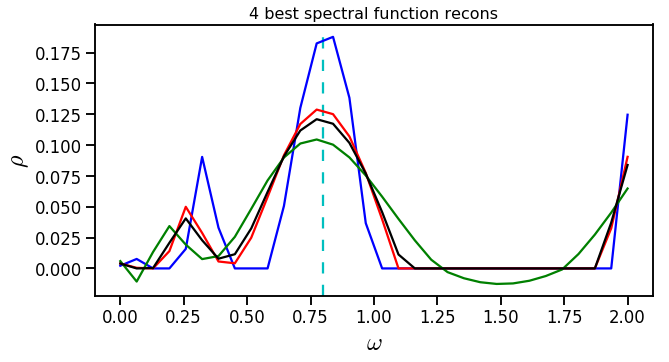

In [20]:
colors = ['b', 'r', 'g', 'k']
with sns.plotting_context('talk'):
    fig, ax = plt.subplots(1, figsize = (10, 5))
    add_line(ax, omega0, color = 'c', dashes = (5, 5), label = '$\\omega_0$')
    for ii in range(n_best):
        plot_1d_function(ax, omega_line, best_rho[ii], colors = colors[ii], title = '4 best spectral function recons', \
                     ax_label = ['$\\omega$', '$\\rho$'], legend = False)